In [12]:
# import all necessary packages for CBOW
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr, spearmanr
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split
from gensim import matutils
from numpy import dot
from sklearn.metrics import accuracy_score

ImportError: cannot import name 'triu' from 'scipy.linalg' (/opt/conda/lib/python3.9/site-packages/scipy/linalg/__init__.py)

In [13]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print device name: get_device_name()
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-32GB


In [14]:
# Load data from file and store list of sentences where sentences are list of words
class MakeSentences():
    def __init__(self, file_name):
        self.file_name = file_name
        self.sentences = self.read_file()

    def read_file(self):
        sentences = []
        with open(self.file_name, 'r') as f:
            i=0
            for line in f:
                sentences += ([x for x in line.strip().split('.') if x!=''])
                i+=1
                if i==10000:
                    break
        return sentences

In [15]:
sentences = MakeSentences('../wikitext-2-raw-v1/wikitext-2-raw/wiki.train.raw').sentences
print(len(sentences))
# for sentence in sentences:
#     print(type(sentence))

25137


In [16]:
print(sentences[0])

= Valkyria Chronicles III =


### Preprocess

In [17]:
import re
from collections import Counter

class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences

    def tokenize(self):
        # Split sentences into words using regex to handle various punctuation
        self.sentences = [re.findall(r'\b\w+\b', sentence.lower()) for sentence in self.sentences]

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]

    def remove_stop_words(self):
        # Common English stop words; expand as necessary
        stop_words = set(["the", "is", "at", "which", "on", "and", "a", "an"])
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def stemmer(self):
        # Simple stemming using suffix stripping, can be improved
        def simple_stem(word):
            suffixes = ["ing", "ly", "ed", "ious", "ies", "ive", "es", "s", "ment"]
            for suffix in sorted(suffixes, key=len, reverse=True):
                if word.endswith(suffix):
                    return word[:-len(suffix)]
            return word
        self.sentences = [[simple_stem(word) for word in sentence] for sentence in self.sentences]

    def remove_punctuation(self):
        self.sentences = [[word for word in sentence if word.isalpha()] for sentence in self.sentences]

    def remove_numbers(self):
        self.sentences = [[word for word in sentence if not word.isdigit()] for sentence in self.sentences]

    def remove_single_letter(self):
        self.sentences = [[word for word in sentence if len(word) > 1] for sentence in self.sentences]

    def remove_extra_spaces(self):
        self.sentences = [[word for word in sentence if word.strip()] for sentence in self.sentences]

    def remove_less_than_3(self):
        self.sentences = [[word for word in sentence if len(word) > 2] for sentence in self.sentences]


In [18]:
# preprocess
preprocess = Preprocess(sentences)
preprocess.tokenize()
# print(preprocess.sentences)
preprocess.lowercase()
preprocess.remove_stop_words()
# preprocess.stemmer()
preprocess.remove_punctuation()
preprocess.remove_numbers()
preprocess.remove_single_letter()
preprocess.remove_extra_spaces()
preprocess.remove_less_than_3()

print("Preprocessing done")
# print(preprocess.sentences)
sentences = preprocess.sentences
print(len(sentences))
# print(sentences)

Preprocessing done
25137


### Create word index mappings

In [19]:
# Flatten list of sentences into list of words
word_list = list(itertools.chain.from_iterable(sentences))
# print(word_list)

# Create a vocabulary of words
word_freq = Counter(word_list)

# Remove words that occur less than 5 times
vocab = set(word if word_freq[word] > 0 else '<unk>' for word in word_list)
# print(vocab)

# Add padding and unknown token to vocab
vocab.add('<pad>')
vocab.add('<unk>')
# Add start and end token to vocab
vocab.add('<start>')
vocab.add('<end>')

# Print length of vocab
print("Size of vocab: ", len(vocab))

# Create word to index and index to word mapping
word_to_idx = {word:idx for idx, word in enumerate(vocab)}
idx_to_word = {idx:word for idx, word in enumerate(vocab)}

# Print most common words
print("Most common words: ", word_freq.most_common(10))

Size of vocab:  30214
Most common words:  [('was', 5340), ('that', 3928), ('for', 3841), ('with', 3758), ('from', 2329), ('his', 2328), ('were', 1987), ('had', 1638), ('are', 1262), ('her', 1248)]


In [20]:
# Check
print(word_to_idx['intelligent'])

10418


### Create dataset (X,y)

In [21]:
# define constants
window_size = 2
sliding_window = 2 * window_size + 1
num_neg_samples = 1

# sentences = [sentences[0]]
# print(sentences)

def get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_sample):
    X = []
    y = [] 
    for sentence in sentences:
        # add start and end token to sentence
        sentence = ['<start>'] + sentence + ['<end>']
        for i in range(len(sentence)):
            target_word = sentence[i]
            # print("target word: ", target_word)
            context_words = []
            temp1 = max(0,i - window_size)
            temp2 = min(len(sentence)-1,i + window_size + 1)
            # print("temp1: ", temp1)
            # print("temp2: ", temp2)
            for j in range(max(0,i - window_size),min(len(sentence)-1,i + window_size)+1):
                if j != i:
                    # print(sentence[j])
                    context_words.append(sentence[j])
                # print("context words: ", context_words)

            
            # pad context words if length is less than sliding window
            if len(context_words) < sliding_window:
                context_words += ['<pad>'] * (sliding_window - len(context_words)-1)
            
            context_words.append(target_word)
            # print("length of context words: ", len(context_words))

            # get positive samples 
            positive_samples = [word_to_idx[word] if word in vocab else word_to_idx['<unk>'] for word in context_words]
            # print("lenght of positive samples: ", len(positive_samples))
            
            X.append(positive_samples)
            y.append(1)


            # get negative samples
            for _ in range(num_neg_samples):
                negative_samples = positive_samples[:-1]  # Start with the same context
                neg_sample = random.choice(list(vocab))
                while neg_sample in context_words:  # Ensure the negative sample is not in the context
                    neg_sample = random.choice(list(vocab))
                
                negative_samples.append(word_to_idx[neg_sample])  # Add a random negative sample
                X.append(negative_samples)
                y.append(0)
                
    return X, y

In [22]:
print("Creating samples")
X = []
y = []
X,y = get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_samples)
print("Samples created")
# print(X)
# print(y)

Creating samples
Samples created


In [23]:
# shuffle data
data = list(zip(X,y))
random.shuffle(data)
X,y = zip(*data)

# Turn into numpy arrays
X = np.array(X)
y = np.array(y)

In [24]:
# Save X and y
np.save('./datasets/wiki_X_25k.npy', X)
np.save('./datasets/wiki_y_25k.npy', y)

In [25]:
# # Load X and y
X = np.load('./datasets/wiki_X_25k.npy')
y = np.load('./datasets/wiki_y_25k.npy')

### Build model

In [26]:
# write the forward pass for CBOW
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        # self.embeddings.weight.data.uniform_(-1, 1)

    def forward(self, x):
        # extract context and target from x
        context = x[:, :-1]
        target = x[:, -1]

        context_embedding = self.embeddings(context)
        context_embedding = torch.mean(context_embedding, dim=1)
        target_embedding = self.embeddings(target)

        # take dot product of context embedding and target embedding
        score = torch.sum(context_embedding * target_embedding, dim=1)
        return F.sigmoid(score)

    def get_embeddings(self):
        out = self.embeddings.weight.data
        return out.cpu().numpy()
    
    def get_word_embedding(self, word):
        # If word is not in vocab, return unk
        if word not in word_to_idx:
            word = '<unk>'
        word_tensor = torch.LongTensor([word_to_idx[word]])
        word_tensor = word_tensor.to(next(self.parameters()).device)
        out = self.embeddings(word_tensor).data
        return out.cpu().numpy()

In [27]:
# Define parameters
vocab_size = len(vocab)
embedding_dim = 100
learning_rate = 0.001
epochs = 10
batch_size = 128

# Create model, loss function and optimizer
model = CBOW(vocab_size, embedding_dim)
model.to(device)
# Cross entropy loss
criterion = nn.BCELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define dataloader
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X).long(), torch.from_numpy(y).float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [28]:
# Check dataset
for i, (inputs, targets) in enumerate(dataloader):
    print(inputs)
    print(targets)
    break

tensor([[ 7589,  7726, 23937, 12758, 22276],
        [ 8528,  5054,  1565,  1565, 20163],
        [ 9940,  3347, 20163,  1565, 21295],
        [15703, 13243, 20163,  1565,  6543],
        [21641, 12938,  8681, 20163, 18809],
        [23506, 27365,  1565,  1565, 20163],
        [22727, 26430, 20163,  1565, 26581],
        [27263, 29818, 18357, 28677, 29152],
        [27285, 12438,  1565,  1565,  9940],
        [ 8428, 28765,  1906, 21534, 12586],
        [22277, 27174, 15606, 21683, 19861],
        [12348, 12522,  1565,  1565, 20163],
        [ 9940, 24365, 25984, 14302,  4015],
        [ 9940, 27146,  9568,  1565, 14704],
        [ 9357, 12451,  4012, 11497,  6601],
        [ 1829, 11955, 11955,   220, 18620],
        [25745,  4060,  1829, 25742, 13192],
        [10005,  8984, 22124,  3029,  2444],
        [25432, 26497, 20950, 27123, 15837],
        [ 8805, 11955,  1906, 27380,  1849],
        [29916,   220, 23401,  6205, 24969],
        [17571,   220,  4726, 20163, 15293],
        [2

In [29]:
# Train CBOW model
def train(model, criterion, optimizer, dataloader, epochs):
    train_losses = []
    for epoch in range(epochs):
        train_loss = 0
        train_preds = []
        labels = []
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # get predictions
            preds = [1 if x > 0.5 else 0 for x in outputs]
            train_preds.extend(preds)
            targets = targets.detach().cpu().numpy()
            labels.extend(targets)
        
        train_loss /= len(dataloader)
        train_losses.append(train_loss)
        print("Epoch: ", epoch+1, "Loss: ", train_loss)
    return train_losses

In [30]:
# Train model
train_losses = train(model, criterion, optimizer, dataloader, epochs)

Epoch:  1 Loss:  1.7010215045741768
Epoch:  2 Loss:  0.9772304872436881
Epoch:  3 Loss:  0.5836373328805095
Epoch:  4 Loss:  0.3555737707908984
Epoch:  5 Loss:  0.2229139288674952
Epoch:  6 Loss:  0.14449637890786907
Epoch:  7 Loss:  0.09615266957107843
Epoch:  8 Loss:  0.06530464448032172
Epoch:  9 Loss:  0.04492391512103596
Epoch:  10 Loss:  0.03108602024434116


In [31]:
# Function to plot train accuracy
def plot_train_losses(train_losses):
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.savefig('./plots/cbow_train_losses_wiki.png')
    plt.show()

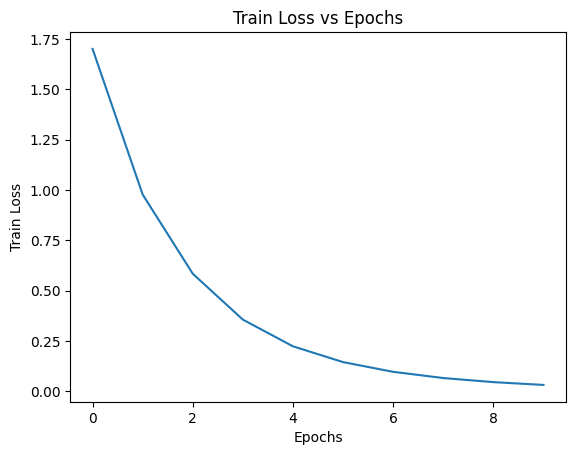

In [32]:
# Call function to plot train accuracy
plot_train_losses(train_losses)

In [33]:
# Save model
torch.save(model.state_dict(), './partA_pth/cbow_25k_100_001.pth')

In [34]:
# Load model
model = CBOW(vocab_size, embedding_dim)
model.load_state_dict(torch.load('./partA_pth/cbow_25k_100_001.pth'))
model.to(device)

CBOW(
  (embeddings): Embedding(30214, 100)
)

### Test model with Wordsim dataset

In [35]:
# Load test data
df = pd.read_csv('../wordsim353/combined.csv')
print(df.head())

     Word 1    Word 2  Human (mean)
0      love       sex          6.77
1     tiger       cat          7.35
2     tiger     tiger         10.00
3      book     paper          7.46
4  computer  keyboard          7.62


In [36]:
# Print 2nd row word1
print(df['Word 1'][1])

tiger


In [37]:
# Get word embeddings
sample_embedding = model.get_word_embedding(df['Word 1'][1])
print(sample_embedding.shape)
sample_embedding = sample_embedding.squeeze()
print(sample_embedding.shape)
print(sample_embedding)
sample_embedding = sample_embedding.reshape(1,-1)
print(sample_embedding.shape)

(1, 100)
(100,)
[-1.8674948   0.27013162  1.4915674  -0.2338258  -2.5056298   2.945772
 -0.27708635  0.14721106  0.7721195   1.4909459  -1.0877306   0.2569368
  2.3024561   0.10378551 -2.0157628  -0.16400751 -0.45565516  0.77827924
 -1.3525712   0.26418704  1.3202723   0.66190153 -0.90911055 -0.46332327
  0.03556557  1.174434    0.25949818  2.013086   -0.5022634   0.60396934
 -1.5864441   0.6320902  -0.86740303  0.04047179 -0.45271736 -0.28891638
  1.454845   -0.43890214 -1.7650582  -0.31302893  0.8616688  -2.219296
 -2.2454698  -2.3862777   0.5364559   0.68477833  0.19684546 -0.5224888
  0.5107017  -0.72853935 -0.636037    0.5360477   0.21698608  0.93642694
 -0.24461909  0.24106207  0.2060979   1.2641404   1.901625    1.6752226
  0.19928132 -0.46982804  1.2444106  -0.83310324  0.83428377  0.3617117
 -0.02164215  0.5760939   0.22540133 -1.8751068   1.5308541   0.1458733
  1.6166972   0.3062213   0.23241809 -1.0668589  -2.4138687   0.20623806
  0.4792228   1.3857622  -0.4630139   0.9370

In [38]:
import numpy as np

# Check similarity between two words
word1 = df['Word 1'][1]
word2 = df['Word 2'][1]

# Use gensim or any other model to get word embeddings
w1 = model.get_word_embedding(word1).squeeze()
w2 = model.get_word_embedding(word2).squeeze()

print(type(w1))

# Calculate cosine similarity using numpy
def unitvec(vec):
    return vec / np.linalg.norm(vec)

sim = np.dot(unitvec(w1), unitvec(w2))
print(sim)


<class 'numpy.ndarray'>
-0.018874682


In [39]:
# Function to check if word is in vocab
def check_vocab(word):
    if word in vocab:
        return True
    else:
        return False

### Similarity Measures

In [40]:
# Function to get cosine similarity
def cos_similarity(word1_embedding, word2_embedding):
    def unitvec(vec):
        return vec / np.linalg.norm(vec)

    ans = np.dot(unitvec(word1_embedding), unitvec(word2_embedding))
    return ans

# Function to get Pearson correlation
def pearson_correlation(word1_embedding, word2_embedding):
    emb1 = np.array(word1_embedding)
    emb2 = np.array(word2_embedding)

    correlation, _ = pearsonr(emb1, emb2)
    return correlation

In [41]:
def test_sim(df, model, lemmatizer, stemmer):
    cosine_similarity_scores = []
    pearson_correlation_scores = []
    scores = []
    
    for _, row in df.iterrows():
        word1 = row['Word 1']
        word2 = row['Word 2']
        
        word1_embedding = model.get_word_embedding(word1).squeeze()
        word2_embedding = model.get_word_embedding(word2).squeeze()

        # Get cosine similarity
        cosine_similarity_scores.append(cos_similarity(word1_embedding, word2_embedding))
        
        # Get pearson correlation
        pearson_correlation_scores.append(pearson_correlation(word1_embedding, word2_embedding))

        # Get score
        scores.append(row['Human (mean)'])
        
    return cosine_similarity_scores, pearson_correlation_scores, scores

In [42]:
# Get cosine similarity and pearson correlation scores
lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
cosine_similarity_scores, pearson_correlation_scores, scores = test_sim(df, model, lemmatizer, stemmer)

In [43]:
# Check cosine similarity and pearson correlation scores
print(type(cosine_similarity_scores))
print(type(pearson_correlation_scores))
print(type(scores))

<class 'list'>
<class 'list'>
<class 'list'>


### Initial Spearman

In [44]:
# Funtcion to get spearman correlation using cosine similarity scores
def spearman_correlation(cosine_similarity_scores, scores):
    # Scale cosine similarity scores to 0-10
    cosine_similarity_scores = np.array(cosine_similarity_scores)
    cosine_similarity_scores = (1+cosine_similarity_scores)*5
    scores = np.array(scores)

    correlation, _ = spearmanr(cosine_similarity_scores, scores)
    return correlation    

In [45]:
# Print the initial spearman correlation
spearman_value = spearman_correlation(cosine_similarity_scores, scores)

print("Initial Spearman correlation: ", spearman_value)

Initial Spearman correlation:  0.08462175488635149


In [37]:
%dropzone -p -src 'cbow_wordsim.ipynb' -tgt 'cbow_wordsim.ipynb'

HTML(value='')

/opt/conda/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
Host key verification failed.
Connection closed


DownloadWidget(children=(HBox(children=(Password(description='Dropzone Password:', style=DescriptionStyle(desc…